# Customer Email Sentiment Analysis for Software Products

## Project Overview

- Our organization specializes in various software products. 
- These products include CRM, ERP, Appointment Booking Software, and more.
- Our task is to develop a machine learning model.
- The goal is to analyze sentiments in customer emails.


**The Problem Statement:**

Our executive team has specific objectives:

- Understand Sentiments: We need to determine sentiments in each email.
- Sentiments could be anger, happiness, or requests for assistance.

**Why Sentiment Analysis?**

Understanding email sentiment is crucial because:

- It enhances customer satisfaction.
- It helps improve product quality.
- It ensures timely support.
- Automating sentiment analysis streamlines customer support processes.
- It identifies areas for product improvement.
- It promptly addresses customer concerns.

This notebook will guide us through:

- Data preprocessing.
- Sentiment analysis for each email.
- Leveraging machine learning and natural language processing.
- Better serving our customers and optimizing our software products.


### Importing all necessary libraries & Modules

In [1]:
import os
import re
import spacy
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report


### Defining the path to email dataset

In [2]:
path_to_email_data = os.path.join(os.path.dirname(os.getcwd()), 'data', 'prod_email.csv')
print(path_to_email_data)

/home/fm-pc-lt-219/Desktop/product_and_sentiment_classification_poc/data/prod_email.csv


### Loading the email dataset

In [3]:
df = pd.read_csv(path_to_email_data)
print(df.shape)
df.head()

(450, 5)


,Ticket Type,Ticket Subject,Ticket Description,new_product_name,new_product_type
0,Technical issue,Software bug,Subject: Urgent Assistance Required: Issue wit...,SAP ERP,ERP
1,Technical issue,Software bug,Subject: Urgent Assistance Required for SAP ER...,SAP ERP,ERP
2,Technical issue,Software bug,Subject: Frustration with SAP ERP Technical Is...,SAP ERP,ERP
3,Technical issue,Software bug,Subject: Urgent Assistance Required: Software ...,SAP ERP,ERP
4,Technical issue,Software bug,Subject: Urgent: Glitch in SAP ERP Software\nD...,SAP ERP,ERP


## Checking the distribution Of Various Ticket Types

In [4]:
df['Ticket Type'].value_counts()

Product inquiry    199
Joyful Shoutout    133
Technical issue    118
Name: Ticket Type, dtype: int64

# Redefining Sentiment Targets

In our sentiment analysis task for customer email messages, we are introducing new target categories to enhance our understanding of customer sentiments:

- **Angry Email**: This category encompasses emails expressing extreme frustration, disappointment, or dissatisfaction with our products or services. These emails often convey negative sentiments and complaints.

- **Happy Email**: Emails falling into this category reflect a positive sentiment. They express satisfaction, gratitude, or appreciation for our products, services, or recent developments. These emails carry a positive tone and may include expressions of thanks.

- **Help Email**: The 'Help Email' category covers messages where customers seek assistance, guidance, or support. These emails indicate that customers are facing challenges or need help with specific issues related to our offerings.

By redefining our target categories, we aim to more accurately classify the sentiments expressed in customer emails. This approach enables us to better understand and respond to their needs and emotions, ultimately leading to more targeted and effective customer support and engagement.


In [5]:
target_map = {"Technical issue": "Angry Email",
              "Joyful Shoutout": "Happy Email",
              "Product inquiry": "Help Email"
             }

In [6]:
df['target'] = df['Ticket Type'].map(target_map)

### Visualizing the distribution of target class

In [7]:
def plot_bar_graph(data, x_col, y_col, title, palette='viridis'):
    """
    Plot a bar graph using Seaborn.

    Parameters:
        data (DataFrame): The DataFrame containing the data.
        x_col (str): The name of the column for the x-axis.
        y_col (str): The name of the column for the y-axis.
        title (str): The title of the plot.
        palette (str, optional): The color palette to use. Default is 'viridis'.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x_col, y=y_col, data=data, palette=palette)

    # Add labels and title
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)

    # Show the plot
    plt.show()


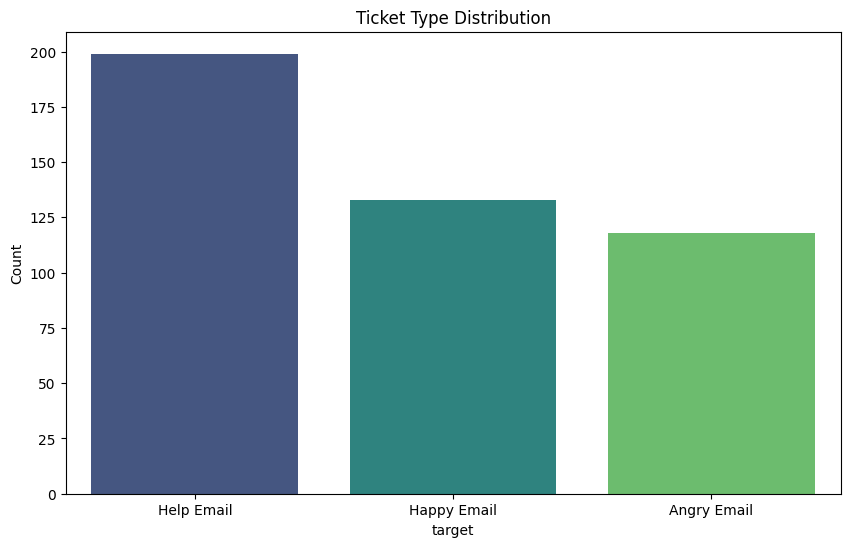

In [8]:
target_df = df['target'].value_counts().reset_index()
target_df.columns = ['target', 'Count']
plot_bar_graph(data=target_df, x_col="target", y_col="Count", title="Ticket Type Distribution")

- Among the 450 emails, 199 fall into the 'Help Email' category.
- A total of 133 emails out of the 450 are categorized as 'Happy Email.'
- Furthermore, 118 out of the 450 emails are classified as 'Angry Email.'


### Loading a spacy model for tokenizing a sentence

**Model: en_core_web_lg**

The "en_core_web_lg" model is a pre-trained language model provided by spaCy. It is designed for various natural language processing (NLP) tasks in English.

**Key Features:**
- **Word Vectors**: This model is equipped with word vectors trained on a large corpus of text data. These word vectors enable it to understand the context and similarity between words, making it suitable for tasks like word embeddings, text similarity analysis and sentiment analysis.

**Training Data:**
- The "en_core_web_lg" model was trained on a diverse range of English text from the web, including news articles, books, and websites. It has been fine-tuned to capture a broad vocabulary and linguistic patterns.

This model serves as a versatile tool for NLP tasks such as text classification, named entity recognition, part-of-speech tagging, and more. It's a valuable resource for understanding and processing English text data efficiently.

**Utilizing the Model for Sentiment Analysis**

In our case, we leverage the capabilities of the "en_core_web_lg" model for conducting sentiment analysis through text classification.

**Categorizing Customer Sentiments**

Our primary objective is to categorize customers based on the sentiments expressed in their emails, particularly focusing on their feedback regarding our products. We aim to classify customers as either happy, expressing dissatisfaction, or seeking assistance based on the content of their emails.




In [9]:
nlp = spacy.load("en_core_web_lg")

### Defining a function to remove commonly used words in a text

<b>Stopwords</b> are common words in natural language that are often filtered out when analyzing text data because they typically don't carry significant meaning on their own. They are frequently used in language but may not provide valuable information for tasks like text analysis and natural language processing. 

Here are two to three examples of common stopwords:

1. English Stopwords:
   - Articles: "a," "an," "the"
   - Pronouns: "I," "you," "he," "she," "it," "we," "they"
   - Prepositions: "in," "on," "at," "with," "by," "for," "of," "to," "from"
   - Conjunctions: "and," "but," "or," "so," "because"

These stopwords are often removed from text data during text preprocessing to focus on more meaningful words and improve the efficiency and effectiveness of natural language processing tasks such as text classification, sentiment analysis, and information retrieval.

In [10]:
def remove_stopwords(text):
    """
    Remove stopwords from the input text.

    Args:
        text (str): The input text from which stopwords will be removed.

    Returns:
        str: The cleaned text with stopwords removed.
    """
    doc = nlp(text)
    cleaned_text = ' '.join(token.text for token in doc if not token.is_stop)
    return cleaned_text

## Text Cleaning

This function performs essential text cleaning steps, making the input text suitable for analysis and natural language processing. The process includes:

- **Tokenization:** Breaking text into words or tokens.
- **Lowercasing:** Converting tokens to lowercase.
- **Punctuation Removal:** Eliminating punctuation marks.
- **Special Character Removal:** Removing non-alphanumeric characters.
- **Whitespace Cleanup:** Ensuring consistent and clean spaces.

The result is a cleaned and preprocessed text, ready for doing Named Entity Recognition(NER).


In [11]:
def clean_text(text):
    """
    Clean and preprocess the input text.

    This function tokenizes the input text, converts tokens to lowercase,
    removes punctuation, and ensures that the text only contains letters,
    digits, and whitespace.

    Args:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned and preprocessed text.
    """
    doc = nlp(text)
    cleaned_text = ' '.join(token.text.lower() for token in doc if not token.is_punct)
    cleaned_text = re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)).strip()
    return cleaned_text

## Applying text cleaning operation in our email description

In [12]:
df['Ticket Description'] = df['Ticket Description'].apply(clean_text)

## Removing stop words from our email description

In [13]:
df['Ticket Description'] = df['Ticket Description'].apply(remove_stopwords)

**Label Encoding in Sentiment Analysis**

Label encoding is the process of converting categorical labels, like class names, into numerical values. In classification problems, we use label encoding to make it easier for machine learning models to process target labels. This conversion is particularly crucial for tasks like sentiment analysis of emails.

In our case, we have three classes: 'Angry Email,' 'Happy Email,' and 'Help Email.' Label encoding assigns numerical values, typically starting from 0, to these categories. For example:

- 'Angry Email' might be encoded as 0.
- 'Happy Email' could be encoded as 1.
- 'Help Email' may receive an encoding of 2.

This encoding simplifies the model's understanding of the categories. In our context, 'Angry Email' represents dissatisfaction or technical issues, 'Happy Email' indicates positive feedback on new features, and 'Help Email' signifies inquiries or requests for assistance. Label encoding streamlines the sentiment classification task, enabling efficient analysis of customer emails.


In [14]:
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['target'])

- Setting the random seed using `np.random.seed(42)` ensures consistent random processes with NumPy.
- It's crucial for reproducibility in scenarios like machine learning experiments.
- The seed value, 42, guarantees the same random results in each code run.
- This consistency aids debugging and result comparison in different program runs.


In [15]:
np.random.seed(42)

## Splitting our dataset as train & test

- `train_test_split` is a function used to split a dataset into two parts: a training set and a testing (or validation) set.
- It's essential for assessing a machine learning model's performance. The training set is used to train the model, and the testing set is used to evaluate its performance on unseen data.
- The `test_size` parameter specifies the proportion of data to include in the testing set. In this case, it's set to 0.2, meaning 20% of the data will be used for testing.
- `random_state` is used to initialize the random number generator. Setting it to a specific value (e.g., 42) ensures that the split is reproducible across different runs of the code.
- `stratify` is used for stratified sampling. When you set it to a variable (in this case, `df['target']`), it ensures that the class distribution in the training and testing sets is similar to the original dataset. This is particularly useful for imbalanced datasets to maintain representative class proportions.

Output:
- Training set (`x_train` and `y_train`) has a shape of (number of samples, number of features).
- Testing set (`x_test` and `y_test`) also has its shape displayed.


In [16]:
X = df['Ticket Description']
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = df['target'])

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(360,)
(360,)
(90,)
(90,)


**TF-IDF Vectorizer (Term Frequency-Inverse Document Frequency Vectorizer)**

- **Role in Text Classification:**
  - TF-IDF Vectorizer is a crucial tool in text classification and natural language processing tasks.
  - Its primary role is to convert a collection of text documents into numerical feature vectors.
  - These feature vectors represent the importance of each word or term within the documents.
  - TF-IDF helps address the issue of textual data's high dimensionality by transforming it into a more manageable numerical format.
  - It assigns numerical weights to terms based on their frequency within a document and their rarity across all documents in the corpus.
  - TF-IDF is essential for text classification because it captures the significance of words in distinguishing one category from another.
  - Words that are frequent in one category but rare in others are given higher weights, aiding the classifier in making accurate predictions.
  - By converting text data into a numerical format, TF-IDF enables the application of machine learning algorithms for classification tasks.

- **How It Works:**
  - TF-IDF stands for Term Frequency-Inverse Document Frequency.
  - It calculates two main components for each term in a document:
    - Term Frequency (TF): Measures how often a term appears in a document. It's calculated as the ratio of the term's frequency to the total number of terms in the document.
    - Inverse Document Frequency (IDF): Measures the rarity of a term across all documents in the corpus. It's calculated as the logarithm of the total number of documents divided by the number of documents containing the term.
  - The TF-IDF score for a term in a document is obtained by multiplying its TF and IDF values.
  - Terms that are frequent within a specific document but rare across the entire corpus receive high TF-IDF scores.
  - The resulting TF-IDF vectors represent documents as numerical feature vectors, where each dimension corresponds to a unique term.
  - These vectors are used as input for machine learning models, enabling text classification based on the importance of terms within documents.

TF-IDF Vectorizer is a powerful tool for text classification as it captures the essence of terms in documents, making it easier for machine learning models to learn and classify text data effectively.


#### TF (Term Frequency):

<li>TF measures how often a word appears in a document.</li>

**Formula:**
<code>
TF(t, d) = (Number of times term t appears in document d) / (Total terms in document d)
</code>

#### IDF (Inverse Document Frequency):

<li>IDF measures the importance of a word across a collection of documents.</li>

**Formula:**

<code>
IDF(t, D) = log(Total documents in corpus |D| / Documents containing term t)
</code>

#### TF-IDF (Term Frequency-Inverse Document Frequency):

<li>TF-IDF combines TF and IDF to compute a weighted score for each word.</li>

**Formula:**

<code>
TF-IDF(t, d, D) = TF(t, d) × IDF(t, D)
</code>

<li>These formulas are essential for text analysis, helping identify word importance in documents, making them valuable for text classification and information retrieval tasks.</li>


In [17]:
tf_idf = TfidfVectorizer()

**Applying TF-IDF Vectorization: Training vs. Testing Datasets**

- **Training Dataset (x_train):**
  - When applying TF-IDF vectorization to the training dataset (x_train), we use the `fit_transform` operation.
  - The `fit_transform` operation serves two primary purposes:
    1. **Fit**: It analyzes the training data to identify all unique terms (words) present in the documents. This step builds the vocabulary.
    2. **Transform**: It transforms the documents in the training dataset into TF-IDF feature vectors based on the learned vocabulary.
  - This is a critical step because it ensures that the TF-IDF vectorizer calculates IDF scores and scales the term frequencies according to the entire training corpus.

- **Testing Dataset (x_test):**
  - When applying TF-IDF vectorization to the testing dataset (x_test), we use the `transform` operation.
  - The `transform` operation only performs the second part of TF-IDF vectorization: transforming the documents into feature vectors.
  - We do not perform the "fit" part because the vocabulary (unique terms) has already been learned from the training dataset.
  - Using the same vocabulary ensures consistency in how terms are represented between the training and testing datasets.
  - This is essential to maintain the integrity of the feature space, as the model must make predictions on data with the same term-to-vector mapping.

In summary, we use `fit_transform` on the training dataset to build the vocabulary and transform the training documents into TF-IDF vectors. For the testing dataset, we use `transform` to apply the same transformation based on the learned vocabulary from the training data. This approach ensures that both datasets are represented consistently in the same feature space, facilitating accurate model predictions.


In [18]:
x_train_tf_idf = tf_idf.fit_transform(x_train)
print(x_train_tf_idf.shape)

(360, 2479)


In [19]:
x_test_tf_idf = tf_idf.transform(x_test)
print(x_test_tf_idf.shape)

(90, 2479)


## Multinomial Naive Bayes for Email Sentiment Classification About Certain Products

**Multinomial Naive Bayes (MultinomialNB)** is a probabilistic machine learning model commonly used for text classification tasks, particularly when dealing with discrete features, such as word counts. It's based on the Naive Bayes algorithm, which is a probabilistic classification method relying on Bayes' theorem. 

### How Multinomial Naive Bayes Works:

**Data Preparation:** The model requires a dataset with features (in this case, TF-IDF values of words) and corresponding target labels (sentiment categories: 'Angry Email,' 'Happy Email,' 'Help Email').

**Training:** During the training phase, the model learns the statistical probabilities of different features (words) occurring in each class (sentiment category). Specifically, it calculates the probabilities of observing each feature (word) given a class (sentiment category).

**Prediction:** In the prediction phase, the model uses these probabilities to classify new, unseen data. For a given input (e.g., a new email represented as TF-IDF values), the model calculates the probability of it belonging to each class based on the features it contains (words). It assigns the class with the highest probability as the predicted class for the input.

### Mathematical Formula:

The core of Naive Bayes algorithms, including Multinomial Naive Bayes, is Bayes' theorem, which relates the conditional probability of an event given prior knowledge to the unconditional probability of that event. In the case of Multinomial Naive Bayes, the formula for classifying an input into class C is:

**P(C∣x) = P(x) * P(C) / P(x∣C)**

Where:

- **P(C∣x)** is the posterior probability of class C given input x.
- **P(C)** is the prior probability of class C.
- **P(x∣C)** is the likelihood of observing input x given class C.
- **P(x)** is the marginal likelihood, representing the probability of observing input x across all classes.

In practice, to calculate **P(x∣C)** for text classification, the Multinomial Naive Bayes classifier makes a crucial assumption of conditional independence between features (words). This means it assumes that the presence of one word in the text does not affect the presence of other words. As a result, the formula is simplified to:

**P(x∣C) = P(word₁∣C) * P(word₂∣C) * … * P(wordₙ∣C)**

Where **word₁, word₂, …, wordₙ** are the words in the input x.

The model calculates these probabilities using the training data and applies Bayes' theorem to classify new data.

In summary, Multinomial Naive Bayes is a probabilistic model that works well for text classification tasks by considering the probabilities of words occurring in each class and making predictions based on these probabilities. It's especially useful for sentiment analysis where the goal is to categorize text data into predefined sentiment categories.

### Training Phase

**During the training phase,** the Multinomial Naive Bayes classifier learns from the training data. It achieves this by calculating probabilities of words occurring in each class (sentiment category) based on the TF-IDF values.

**Model Building:** The classifier builds a model that can distinguish between 'Angry Email,' 'Happy Email,' and 'Help Email' based on these calculated probabilities.

### Prediction Phase

**Once the model is trained,** we can use it to predict the sentiment categories of new email messages. These messages are represented as TF-IDF values.

**Test Dataset:** In this case, we have the test dataset (x_test_tf_idf) containing a set of email messages that the model has never seen before.

### Making Predictions

**To make predictions,** we call the predict method on the trained classifier (clf).

**Input:** We pass in the TF-IDF values of the test emails (x_test_tf_idf).

**Classifier Knowledge:** The classifier applies its learned knowledge to calculate the likelihood of each email belonging to each sentiment category ('Angry Email,' 'Happy Email,' 'Help Email').

### Output

**The output** of the prediction process is a set of predicted sentiment categories for each email in the test dataset.

**Result (y_pred):** These predicted categories (y_pred) represent the model's best guess at the sentiment expressed in each email.

### Summary

**In summary,** once we train a Multinomial Naive Bayes classifier, we can utilize it to classify new email messages into sentiment categories. This automated process helps us categorize and analyze customer feedback effectively.

In [20]:
clf = MultinomialNB()
clf.fit(x_train_tf_idf, y_train)

MultinomialNB()

In [21]:
y_pred = clf.predict(x_test_tf_idf)

#### Performance Metrics

- In our problem of classifying customer feedback emails into sentiment categories ('Angry Email,' 'Happy Email,' 'Help Email'), we use the following performance metrics:

- <b>Accuracy Score:</b> Measures overall correctness in classifying sentiments.

- <b>Precision:</b> Focuses on accurately identifying each sentiment category, vital for avoiding misclassification.

- <b>Recall (Sensitivity):</b> Ensures we capture as many instances of each sentiment category as possible, reducing the risk of missing critical feedback.

- <b>F1 Score:</b> Balances precision and recall, ideal for finding a compromise between accuracy and coverage.

- <b>Classification Report:</b> Provides a detailed breakdown of metrics for each sentiment category, helping us identify specific strengths and weaknesses.



In [22]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

report = classification_report(y_test, y_pred)
print(report)


Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        40

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



# Performance Evaluation

**Accuracy:** An accuracy of 1.00 indicates that the model correctly classified all emails in the test dataset. This may suggest that the model performed exceptionally well.

**Precision:** Precision measures the accuracy of positive predictions. The precision of 1.00 for all classes implies that there were no false positives in any sentiment category. This is an impressive result.

**Recall:** Recall, or sensitivity, measures the model's ability to capture all positive instances. Again, a score of 1.00 for all categories suggests that the model didn't miss any positive instances.

**F1-Score:** The F1-score is the harmonic mean of precision and recall. Its perfect score of 1.00 for all classes indicates a well-balanced performance between precision and recall.

## Justification of High Accuracy

The high accuracy observed can be attributed to a few factors:

1. **Biased Data Generation:** If the model was trained or fine-tuned using data generated by ChatGPT, it might have learned to mimic the patterns and biases present in that data. This could lead to high accuracy when tested on similar data generated by the same model.

2. **Specific Prompts:** If the email generation process relies heavily on specific prompts that control the content and sentiment, the model may excel at producing the desired sentiment categories. However, this may not reflect the real-world scenario of customer feedback, where the content is more diverse and unstructured.

## Conclusion

While the model's high accuracy is impressive within the context of the data it was tested on, it's essential to recognize that real-world customer feedback is far more complex and varied. Achieving such high accuracy in a controlled setting does not guarantee similar performance in a genuine customer feedback scenario. Therefore, further evaluation and testing on diverse, real-world data are necessary to assess the model's practical utility and robustness in a more realistic context.


### Saving label encoder and classifier model for model inference

In [27]:
classifier_filename = 'classifier_model.pkl'
label_encoder_filename = 'label_encoder.pkl'
tfidf_vectorizer_filename = "tfidf_vectorizer.pkl"

path_to_classifier = os.path.join(os.path.dirname(os.getcwd()), 'models', classifier_filename)
path_to_label_encoder = os.path.join(os.path.dirname(os.getcwd()), 'models', label_encoder_filename)
path_to_tfidf_vectorizer = os.path.join(os.path.dirname(os.getcwd()), 'models', tfidf_vectorizer_filename)
print(path_to_classifier)
print(path_to_label_encoder)
print(path_to_tfidf_vectorizer)

/home/fm-pc-lt-219/Desktop/product_and_sentiment_classification_poc/models/classifier_model.pkl
/home/fm-pc-lt-219/Desktop/product_and_sentiment_classification_poc/models/label_encoder.pkl
/home/fm-pc-lt-219/Desktop/product_and_sentiment_classification_poc/models/tfidf_vectorizer.pkl


### Save the classifier model

In [24]:
with open(path_to_classifier, 'wb') as file:
    pickle.dump(clf, file)

### Save the label encoder

In [25]:
with open(path_to_label_encoder, 'wb') as file:
    pickle.dump(label_encoder, file)


### Save the TFIDF Vectorizer

In [28]:
with open(path_to_tfidf_vectorizer, 'wb') as file:
    pickle.dump(tf_idf, file)